In [231]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

## Create a model to predict the delays

#### Through this workbook,I am goin to answer below questions:
* Create a model to predict flight delays?
* How well does weather predict plane delays?

In [135]:
df_2008=pd.read_csv('2008.csv')
df_2007=pd.read_csv('2007.csv')
airport_df=pd.read_csv('airports.csv')
carrier_df=pd.read_csv('carriers.csv')
planes_df=pd.read_csv('plane-data.csv')
main_df=pd.concat([df_2008],ignore_index=True)

In [136]:
main_df['Date']=pd.to_datetime(pd.DataFrame({'year':main_df['Year'],'month':main_df['Month'],'day':main_df['DayofMonth']}))

#### Problem statement - Is there any delay in the flight or not? If there is a delay do that is Dep Delay or Arr Delay or both or None. IF so how much of departure delay and how much of arrival delay
There are two regression problems in this questions.
#### Problem Statement1 - How much is Departure Delay for this particural plane
#### Problem Statement2 - How much is Arrival Delay for this particural plane
Key parameters can be considered are:
Target parameter: DepDelay or Arr Delay (Prepare a column Total Delay)
#### Problem1 model below

In [137]:
main_df.columns
key_columns=['CRSDepTime','CRSArrTime','UniqueCarrier','AirTime','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
            'LateAircraftDelay','Month','DayOfWeek','DepDelay']
key2_columns=['UniqueCarrier','Diverted','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay',
            'LateAircraftDelay','Month','DayOfWeek','DepDelay']

In [138]:
main_df_req=main_df[key2_columns].copy()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


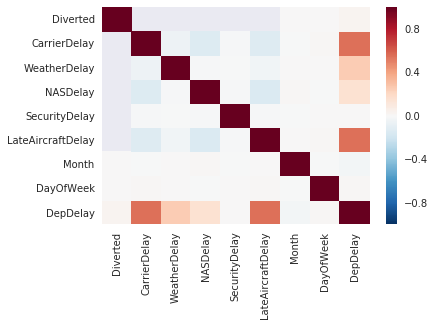

In [139]:
sns.heatmap(main_df_req.corr())

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


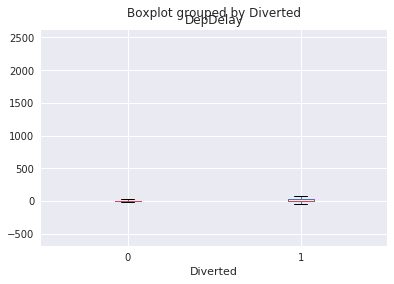

In [140]:
main_df_req.boxplot(column='DepDelay',by='Diverted')

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:450: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


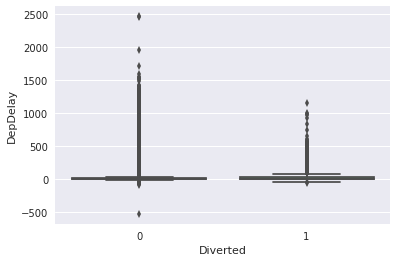

In [141]:
sns.boxplot(x='Diverted',y='DepDelay',data=main_df_req)

In [142]:
main_df_req['DepDelay'].describe(percentiles=[0.01,0.05,0.95,0.99])

count    6.873482e+06
mean     9.972570e+00
std      3.531127e+01
min     -5.340000e+02
1%      -1.200000e+01
5%      -9.000000e+00
50%     -1.000000e+00
95%      7.000000e+01
99%      1.640000e+02
max      2.467000e+03
Name: DepDelay, dtype: float64

In [143]:
print(main_df_req.columns)
lst=list(main_df_req['UniqueCarrier'].unique())
print(lst)
main_df_req1=main_df_req[main_df_req['DepDelay'].isnull()==False].fillna(0)

Index(['UniqueCarrier', 'Diverted', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'Month', 'DayOfWeek', 'DepDelay'],
      dtype='object')
['WN', 'XE', 'YV', 'OH', 'OO', 'UA', 'US', 'DL', 'EV', 'F9', 'FL', 'HA', 'MQ', 'NW', '9E', 'AA', 'AQ', 'AS', 'B6', 'CO']


In [144]:
main_df['DayOfWeek'].unique()

array([4, 5, 6, 7, 1, 2, 3])

In [145]:
Unq_carr=tf.feature_column.categorical_column_with_hash_bucket('UniqueCarrier',hash_bucket_size=20)
diver=tf.feature_column.categorical_column_with_vocabulary_list('Diverted',[1,0])
Car_del=tf.feature_column.numeric_column('CarrierDelay')
wt_del=tf.feature_column.numeric_column('WeatherDelay')
Nas_del=tf.feature_column.numeric_column('NASDelay')
Sec_del=tf.feature_column.numeric_column('SecurityDelay')
Late_del=tf.feature_column.numeric_column('LateAircraftDelay')
Month=tf.feature_column.categorical_column_with_vocabulary_list('Month',[1,2,3,4,5,6,7,8,9,10,11,12])
DayOfWeek=tf.feature_column.categorical_column_with_vocabulary_list('DayOfWeek',[1,2,3,4,5,6,7])
DepDelay=tf.feature_column.numeric_column('DepDelay')
Unq_car=tf.feature_column.indicator_column(Unq_carr)
diverted=tf.feature_column.indicator_column(diver)
day_week=tf.feature_column.indicator_column(DayOfWeek)
day_mnth=tf.feature_column.indicator_column(Month)

In [172]:
feat_cols=[Unq_car,diverted,Car_del,wt_del,Nas_del,Sec_del,Late_del,day_mnth,day_week]
x_train,x_test,y_train,y_test=train_test_split(main_df_req1.iloc[:,:-1],main_df_req1.iloc[:,-1],random_state=100,train_size=0.8)

Create an input function

In [183]:
input_func=tf.estimator.inputs.pandas_input_fn(x=x_train,y=y_train,batch_size=100,num_epochs=11,shuffle=False)
test_func=tf.estimator.inputs.pandas_input_fn(x=x_test,y=y_test,batch_size=100,num_epochs=11,shuffle=False)

Create DNNRegressor model

In [239]:
model=tf.estimator.DNNRegressor(feature_columns=feat_cols,hidden_units=[10,30,30,30,10],activation_fn=tf.nn.relu,
                                optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=0.05,l1_regularization_strength=0.001),
                               model_dir=os.getcwd()+'/model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_service': None, '_task_type': 'worker', '_save_summary_steps': 100, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_num_ps_replicas': 0, '_is_chief': True, '_save_checkpoints_secs': 600, '_keep_checkpoint_max': 5, '_model_dir': '/content/datalab/notebooks/model', '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb574e46390>, '_task_id': 0, '_master': '', '_log_step_count_steps': 100, '_session_config': None}


In [234]:
print(os.getcwd())

/content/datalab/notebooks


In [240]:
model.train(input_fn=input_func,steps=2500)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /content/datalab/notebooks/model/model.ckpt.
INFO:tensorflow:step = 1, loss = 77659.9
INFO:tensorflow:global_step/sec: 228.397
INFO:tensorflow:step = 101, loss = 14652.742 (0.447 sec)
INFO:tensorflow:global_step/sec: 213.116
INFO:tensorflow:step = 201, loss = 9804.433 (0.465 sec)
INFO:tensorflow:global_step/sec: 218.211
INFO:tensorflow:step = 301, loss = 11387.388 (0.459 sec)
INFO:tensorflow:global_step/sec: 215.529
INFO:tensorflow:step = 401, loss = 5215.9404 (0.460 sec)
INFO:tensorflow:global_step/sec: 219.342
INFO:tensorflow:step = 501, loss = 4780.608 (0.456 sec)
INFO:tensorflow:global_step/sec: 212.579
INFO:tensorflow:step = 601, loss = 5432.058 (0.472 sec)
INFO:tensorflow:global_step/sec: 215.642
INFO:tensorflow:step = 701, loss = 6199.977 (0.465 sec)
INFO:tensorflow:global_step/sec: 216.697
INFO:tensorflow:step = 801, loss = 9588.434 (0.462 sec)
INFO:tensorflow:global_step/sec: 214.364
INFO

In [241]:
ev=model.evaluate(input_fn=input_func,steps=100)
print(ev)
# towfurther tweak the model if we add rmse is part of evaluation metrics https://www.tensorflow.org/versions/r1.3/extend/estimators#constructing-modelfn

INFO:tensorflow:Starting evaluation at 2018-05-04-16:20:15
INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-2500
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-05-04-16:20:15
INFO:tensorflow:Saving dict for global step 2500: average_loss = 82.01227, global_step = 2500, loss = 8201.227
{'global_step': 2500, 'average_loss': 82.01227, 'loss': 8201.227}


In [242]:
y_pred=model.predict(input_fn=test_func)
y_pred_test=model.predict(input_fn=input_func)
y_pred1=[]
for i in range(500000):
  y_pred1.append(next(y_pred))
exact_pred=[i['predictions'][0] for i in y_pred1]
y_train_pred=[]
for i in range(500000):
  y_train_pred.append(next(y_pred_test))
exact_train=[i['predictions'][0] for i in y_train_pred]

Exception ignored in: <generator object Estimator.predict at 0x7fb574e360f8>
Traceback (most recent call last):
  File "/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 440, in predict
    for key, value in six.iteritems(preds_evaluated)
  File "/usr/local/envs/py3env/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/usr/local/envs/py3env/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4647, in get_controller
    type(default))
AssertionError: Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects


INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-2500
INFO:tensorflow:Restoring parameters from /content/datalab/notebooks/model/model.ckpt-2500


In [243]:
from sklearn.metrics import mean_squared_error,r2_score
#print(mean_squared_error(y_test[0:len(exact_pred)],exact_pred))
print("Model Accuracy on test data is {} ".format(r2_score(y_test[0:len(exact_pred)],exact_pred)))
#print(mean_squared_error(y_train[0:len(exact_train)],exact_train))
print("Model Accuracy on train data is {} ".format(r2_score(y_train[0:len(exact_pred)],exact_train)))

Model Accuracy on test data is 0.9299606595940411 
Model Accuracy on train data is 0.9270839339833001 


In [247]:
model.get_variable_value(model.get_variable_names()[0])

array([-0.34271473,  0.00671753,  0.11543884,  0.23377183,  0.09515811,
        0.34150186,  0.39087343,  0.04226578,  0.2889858 , -0.8780768 ],
      dtype=float32)

In [251]:
model.get_variable_value(model.get_variable_names()[5])

array([2.2519038e+06, 2.9160580e+07, 3.0388722e+07, 1.0951514e+07,
       3.5894281e+04, 1.0420382e+08, 5.1590788e+07, 8.7311859e+00,
       6.6957844e+07, 1.0641035e+08, 1.3827319e+07, 1.8864728e+06,
       1.2861621e+08, 9.7954576e+07, 3.7187860e+07, 1.3821417e+07,
       4.6945420e+07, 2.2584021e+02, 1.5907749e+08, 1.1645870e+08,
       8.5369024e+07, 2.4518869e+08, 1.4049160e+04, 1.8592948e+07,
       6.9605648e+07, 8.9832632e+07, 1.1188794e+07, 4.6288348e+07,
       1.5849202e+06, 1.3823688e+07], dtype=float32)